# Using `datasaver_builder` and `dond_into` to streamline measurements

This example notebook shows examples of how to use the `datasaver_builder` and `dond_into` extensions together. It showcases these as an intermediate abstraction layer between the low-level `Measurement` object and the high-level `doNd` routines.


## Setup

Here, we call necessary imports for running this notebook, as well as setting up a database, dummy parameters, and creating an experiment object.

### Main Module Imports
These are the main components we'll be looking at in this notebook.

In [1]:
from qcodes.dataset import DataSetDefinition, LinSweeper, datasaver_builder, dond_into

### Other imports

In [2]:
from itertools import product
from pathlib import Path

import numpy as np

from qcodes.dataset import (
    LinSweep,
    Measurement,
    initialise_or_create_database_at,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.parameters import Parameter, ParameterWithSetpoints
from qcodes.validators import Arrays

### Set up database and experiment

In [3]:
db_path = Path.cwd().parent / "example_output" / "measurement_extensions.db"
initialise_or_create_database_at(db_file_with_abs_path=db_path)
experiment = load_or_create_experiment("Examples")

### Dummy Parameter Creation

In [4]:
set1 = Parameter("set1", get_cmd=None, set_cmd=None, initial_value=0)
set2 = Parameter("set2", get_cmd=None, set_cmd=None, initial_value=0)
set3 = Parameter("set3", get_cmd=None, set_cmd=None, initial_value=0)


def get_set1():
    return set1()


def get_sum12():
    return set1() + set2()


def get_diff13():
    return set1() - set3()


meas1 = Parameter("meas1", get_cmd=get_set1, set_cmd=False)
meas2 = Parameter("meas2", get_cmd=get_sum12, set_cmd=False)
meas3 = Parameter("meas3", get_cmd=get_diff13, set_cmd=False)

### ParameterWithSetpoints Creation

In [5]:
def get_setpoints_array():
    return np.linspace(-5, 5, 11)


def get_pws_results():
    setpoints_arr = get_setpoints_array()
    return setpoints_arr**2 * set1()


setpoint_array = Parameter(
    "setpoints", get_cmd=get_setpoints_array, vals=Arrays(shape=(11,))
)

pws = ParameterWithSetpoints(
    "pws",
    setpoints=(setpoint_array,),
    get_cmd=get_pws_results,
    vals=Arrays(shape=(11,)),
)

## Using the `datasaver_builder`

The `datasaver_builder` is a shortcut to creating multiple qcodes `Measurement` objects, registering the relevant parameters and dependencies, and entering the datasaver context managers.

This process begins with the `DataSetDefinition`, a dataclass specifying the name of the dataset, the independent parameters, the dependent parameters, and optionally the experiment to write the dataset to. If the experiment kwarg is omitted, Qcodes will write to the default experiment. Note that the `datasaver_builder` assumes that all dependent parameters depend on all independent parameters. This is less flexible than the raw `Measurement` object, but covers the most common measurement types.

Once the datasets have been defined, we enter the `datasaver_builder` by passing the list or tuple of `DataSetDefinition` objects.

When we enter the context manager, we get a list of the respective datasavers, in an order which matches the order passed. These can be accessed like any other `DataSaver`, and arbitrary code can be executed in whatever order is needed. When the measurement is complete, these datasavers can then be assigned to datasets which can be plotted.

Starting experimental run with id: 1. 
Starting experimental run with id: 2. 


([<Axes: title={'center': 'Run #2, Experiment Examples (some_sample)'}, xlabel='set1', ylabel='set3'>],
 [<matplotlib.colorbar.Colorbar at 0x7f477b4d94d0>])

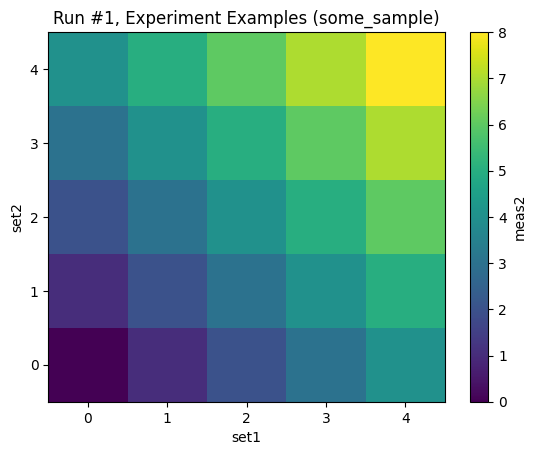

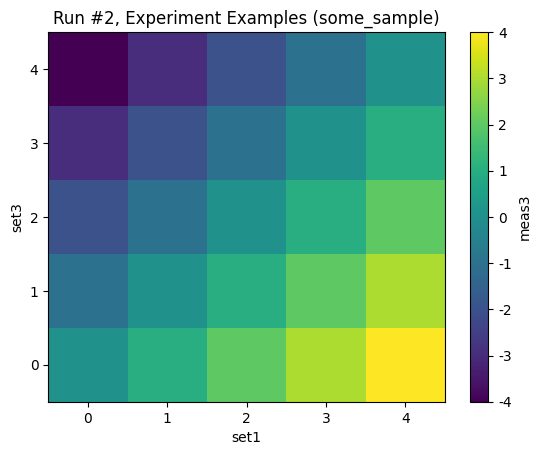

In [6]:
dataset_definition = [
    DataSetDefinition(
        name="dataset_1",
        independent=[set1, set2],
        dependent=[meas2],
        experiment=experiment,
    ),
    DataSetDefinition(
        name="dataset_2",
        independent=[set1, set3],
        dependent=[meas3],
        experiment=experiment,
    ),
]
with datasaver_builder(dataset_definition) as datasavers:
    for val1, val2, val3 in product(range(5), repeat=3):
        set1(val1)
        set2(val2)
        set3(val3)
        meas2_val = meas2()
        meas3_val = meas3()
        datasavers[0].add_result((set1, val1), (set2, val2), (meas2, meas2_val))
        datasavers[1].add_result((set1, val1), (set3, val3), (meas3, meas3_val))
    datasets = [datasaver.dataset for datasaver in datasavers]

plot_dataset(datasets[0])
plot_dataset(datasets[1])

## Using `dond_into`
`dond_into` is a dond-like utility function which performs gridded measurements and writes them to a specified datasaver. Unlike `dond` however, `dond_into` can write to the same datasaver -- and thus the same dataset -- multiple times. There are caveats, though.
1. `dond_into` will not stop a user from measuring the same data point more than once, which may lead to unexpected output shapes, especially when converted to an xarray.
2. `dond_into` does not support `TogetherSweeps` or multiple datasets via grouping parameters. These arguments will raise Exceptions if passed.

In this example, we take two slices from the same measurement function: one at low resolution, and another at high resolution. Both sets of data are then written to the same dataset.


Starting experimental run with id: 3. 


([<Axes: title={'center': 'Run #3, Experiment Examples (some_sample)'}, xlabel='set1', ylabel='meas1'>],
 [None])

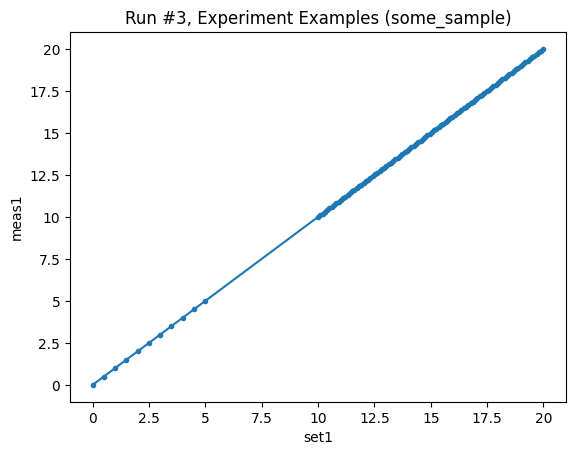

In [7]:
core_test_measurement = Measurement(name="core_test_1", exp=experiment)
core_test_measurement.register_parameter(set1)
core_test_measurement.register_parameter(meas1, setpoints=[set1])
with core_test_measurement.run() as datasaver:
    sweep1 = LinSweep(set1, 0, 5, 11, 0.001)
    dond_into(datasaver, sweep1, meas1)

    sweep2 = LinSweep(set1, 10, 20, 100, 0.001)
    dond_into(datasaver, sweep2, meas1)

    dataset = datasaver.dataset
plot_dataset(dataset, marker=".")

## Using `datasaver_builder` with `dond_into` and `LinSweeper`

Put together, the `datasaver_builder` and `dond_into` extensions provide a clean way of writing flexible measurement code that too complicated for `dond` yet too simple for the full power of the `Measurement` object.

In the example below, we also introduce a new class, the `LinSweeper`. This is an iterable that sets the given swept parameter according to the inputs. It is useful for building outer-loops, within which more detailed measurements or functions are called. Once again, arbitrary code blocks can be included, simplifying the equivalent of dond's `enter_actions`, `exit_actions`, and `break_conditions` kwargs. Instead of being arguments, they can be explicitly included in the measurement, and can be nested precisely where the user wants them.

Starting experimental run with id: 4. 
Starting experimental run with id: 5. 


([<Axes: title={'center': 'Run #5, Experiment Examples (some_sample)'}, xlabel='set1', ylabel='set3'>],
 [<matplotlib.colorbar.Colorbar at 0x7f477b33aa10>])

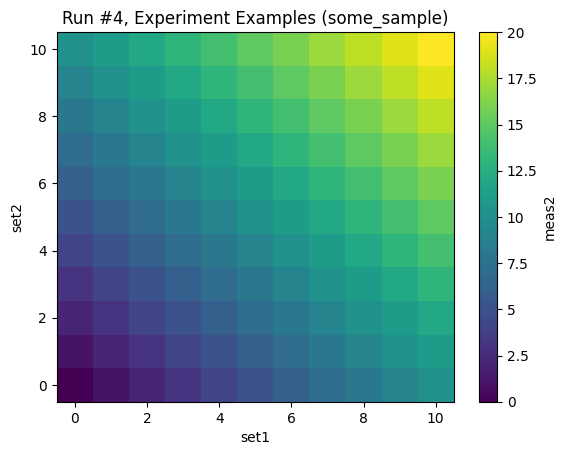

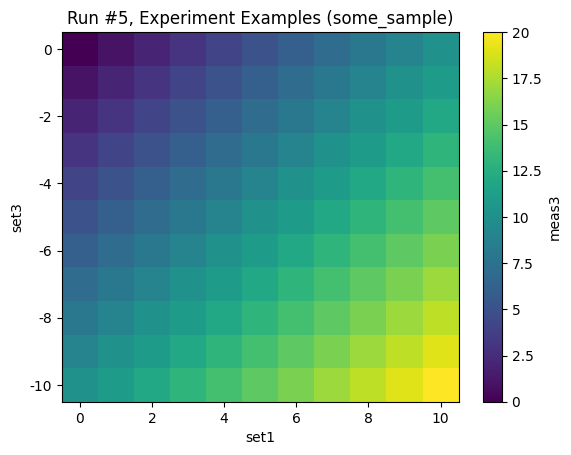

In [8]:
dataset_definition = [
    DataSetDefinition(name="dataset_1", independent=[set1, set2], dependent=[meas2]),
    DataSetDefinition(name="dataset_2", independent=[set1, set3], dependent=[meas3]),
]
with datasaver_builder(dataset_definition) as datasavers:
    for _ in LinSweeper(set1, 0, 10, 11, 0.001):
        sweep1 = LinSweep(set2, 0, 10, 11, 0.001)
        sweep2 = LinSweep(set3, -10, 0, 11, 0.001)
        dond_into(datasavers[0], sweep1, meas2, additional_setpoints=(set1,))
        dond_into(datasavers[1], sweep2, meas3, additional_setpoints=(set1,))
    datasets = [datasaver.dataset for datasaver in datasavers]

plot_dataset(datasets[0])
plot_dataset(datasets[1])

## Using `datasaver_builder` and `dond_into` with `ParameterWithSetpoints`

One final use case includes support for the `ParameterWithSetpoints`. As seen below, the `datasaver_builder` and `dond_into` behave intuitively with these special parameters.

Starting experimental run with id: 6. 


([<Axes: title={'center': 'Run #6, Experiment Examples (some_sample)'}, xlabel='set1', ylabel='setpoints'>],
 [<matplotlib.colorbar.Colorbar at 0x7f477b2663d0>])

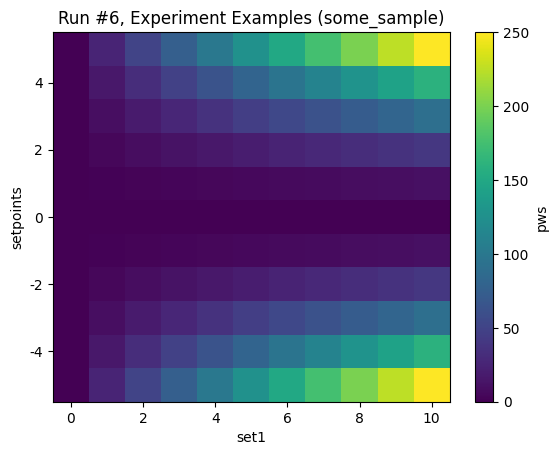

In [9]:
dataset_definition = [
    DataSetDefinition(name="dataset_1", independent=[set1], dependent=[pws])
]
with datasaver_builder(dataset_definition) as datasavers:
    for _ in LinSweeper(set1, 0, 10, 11, 0.001):
        dond_into(datasavers[0], pws, additional_setpoints=(set1,))

    datasets = [datasaver.dataset for datasaver in datasavers]

plot_dataset(datasets[0])